In [27]:
import matplotlib.pyplot as plt
import os
import shutil
import xml.etree.ElementTree as ET
from re import sub
import cv2
import numpy as np


In [ ]:
# Mount Google Drive (optional, if you want to save the dataset)
from google.colab import drive
drive.mount('/content/drive')

In [1]:
"""

# Create a directory and download the dataset
!mkdir -p /content/object_count_dataset
%cd /content/object_count_dataset



# Download Pascal VOC 2012 (Only ~2GB compressed, but we will clean it up)
!wget -c http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

# Extract only JPEGImages and Annotations (Removes other large files)
!tar -xf VOCtrainval_11-May-2012.tar VOCdevkit/VOC2012/JPEGImages VOCdevkit/VOC2012/Annotations

# Remove the large compressed file after extraction to save space
!rm VOCtrainval_11-May-2012.tar"""


Mounted at /content/drive
/content/object_count_dataset
--2025-02-05 11:22:27--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  23.1MB/s    in 86s     

2025-02-05 11:23:53 (22.3 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:


# Define paths
image_dir = "/content/object_count_dataset/VOCdevkit/VOC2012/JPEGImages"
annotation_dir = "/content/object_count_dataset/VOCdevkit/VOC2012/Annotations"

# Create smaller dataset folders
small_image_dir = "/content/object_count_dataset/VOC_small/JPEGImages"
small_annotation_dir = "/content/object_count_dataset/VOC_small/Annotations"
os.makedirs(small_image_dir, exist_ok=True)
os.makedirs(small_annotation_dir, exist_ok=True)

# Select a small subset (e.g., 1000 images)
num_samples = 1000
images = sorted(os.listdir(image_dir))[:num_samples]

for img in images:
    img_path = os.path.join(image_dir, img)
    ann_path = os.path.join(annotation_dir, img.replace(".jpg", ".xml"))

    # Copy only selected images and annotations
    shutil.copy(img_path, small_image_dir)
    if os.path.exists(ann_path):
        shutil.copy(ann_path, small_annotation_dir)

# Remove the original large dataset to free space
shutil.rmtree("/content/object_count_dataset/VOCdevkit")

print(f"Dataset reduced to {len(os.listdir(small_image_dir))} images.")


Dataset reduced to 1000 images.


In [5]:
# Check final dataset size
print("Final dataset size (JPEGImages):", len(os.listdir(small_image_dir)))
print("Final dataset size (Annotations):", len(os.listdir(small_annotation_dir)))


Final dataset size (JPEGImages): 1000
Final dataset size (Annotations): 1000


## Explore the data


In [13]:
annotation_file = "/content/object_count_dataset/VOC_small/Annotations/2007_000027.xml"
tree = ET.parse(annotation_file)
root = tree.getroot()
for child in root:
    print(child.tag, child.attrib)


folder {}
filename {}
source {}
size {}
segmented {}
object {}


In [21]:
for child in root:
    if child.tag == "object":
        for sub_child in child:
            if sub_child.tag == "name":
                print(sub_child.text)


person


In [26]:
for child in root:
    if child.tag == "object":
        for sub_child in child:
            if sub_child.tag == "bndbox":
                for subsub_child in sub_child:
                    if subsub_child.tag in ["xmin", "ymin", "xmax", "ymax"]:
                        print(subsub_child.text)


174
101
349
351


## Preprocessing


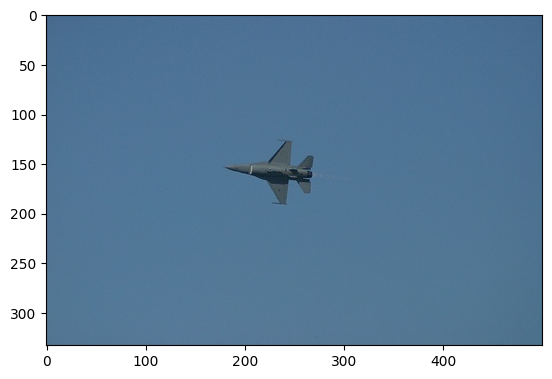

In [85]:
images_file = "/content/object_count_dataset/VOC_small/JPEGImages/2007_000243.jpg"
image = cv2.imread(images_file)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image )

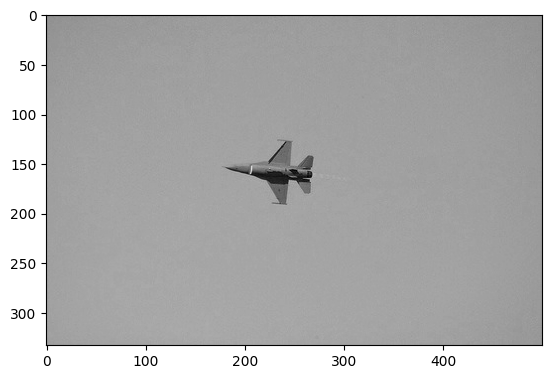

In [86]:
#plt.imshow expects the image to be in the RGB format, but the image you’re passing is in grayscale (single channel).

gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

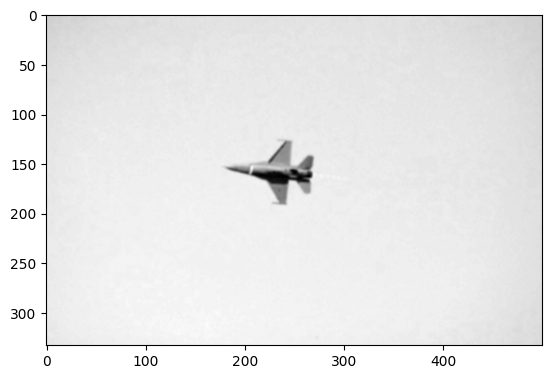

In [89]:
# Apply Gaussian blur to reduce noise ( image ,kernel size , standard deviation of the kernel in the X and Y directions. Setting it to 0 means OpenCV will calculate the optimal value automatically )
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred, cmap='gray')


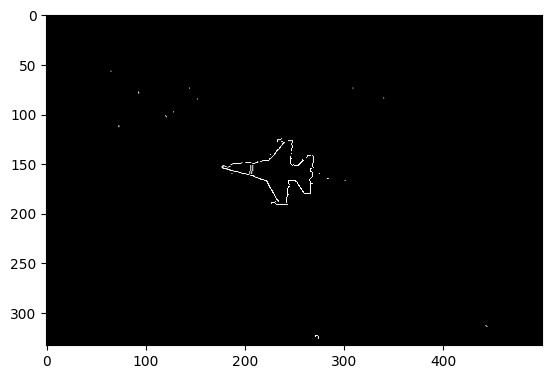

In [117]:
## Lower Threshold
##Defines the minimum intensity gradient required to be considered an edge.
##Upper Threshold
##Defines the maximum intensity gradient for an edge.
equ_gray= cv2.equalizeHist(gray)

edges = cv2.Canny(equ_gray, 700, 800)

plt.imshow(edges, cmap='gray')



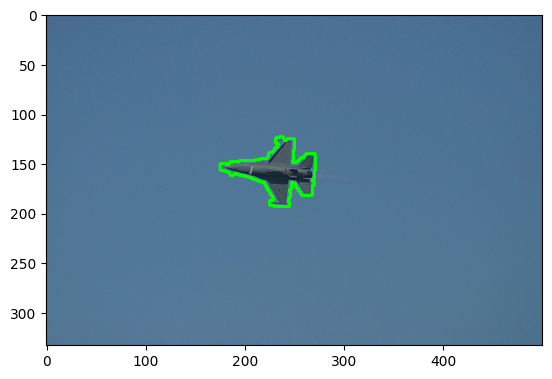

In [136]:
#contours in a binary image. Contours are curves that join continuous points along a boundary of an object.
contoured,hierarchy=cv2.findContours(edges,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#expands the white areas in a binary image. It is particularly useful for connecting broken edges and closing small gaps in contours.
#kernel determines how much the white areas
kernel = np.ones((5, 5), np.uint8)
#Dilation means that white pixels (edges) "spread out" in all directions, following the shape of the kernel.
#iterations=1 means the dilation process runs once
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

contours, hierarchy = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the image
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500:
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)

# Show result
plt.imshow(contour_image)


In [146]:
min_area = 100

# Filter out small contours
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

num_objects = len(filtered_contours)  # Count the number of detected contours
print(f"Number of objects detected: {num_objects}")


Number of objects detected: 1
